In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from typing import Dict, List, Tuple
from tensorflow.keras import layers, models
from typing import List, Dict, Tuple, Optional
from pathlib import Path



In [2]:
df = pd.read_csv("/Users/sohinikar/FL/M.Tech_Dissertation/Obfuscated-MalMem2022_train_and_test.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
1,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
2,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign
4,Benign,40,12,13.800000,0,306.950000,2082,52.050000,12278,306.950000,...,222,26,27,118,0,123,88,0,8,Benign


In [3]:
df.shape

(52708, 57)

In [4]:
df.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,5.270800e+04,52708.000000,52708.0,...,52708.000000,52708.000000,52708.000000,52708.000000,52708.000000,52708.0,52708.000000,52708.000000,52708.000000,52708.000000
mean,41.398972,14.721731,11.338282,0.0,247.386149,1810.511023,43.694839,1.025501e+04,249.447942,0.0,...,391.341011,221.405916,25.996338,25.059308,116.877552,0.0,121.994574,86.903127,0.000797,7.999886
std,5.779682,2.655174,1.587059,0.0,116.714088,329.846663,5.737274,5.066323e+03,153.023360,0.0,...,4.522731,1.985979,0.165994,1.528529,1.553418,0.0,2.825147,3.134089,0.028217,0.010669
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.971429,0.0,208.700000,1556.000000,38.829268,8.393000e+03,209.634146,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.759132,1730.000000,42.731409,9.275500e+03,246.794279,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.858038,0.0,289.728806,2087.000000,49.563324,1.219200e+04,291.287373,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [5]:
df.shape

(52708, 57)

# Data Cleaning

In [6]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [7]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [9]:
df['Class'] = df['Class'].map({'Benign': 0, 'Malware': 1}) if df['Class'].dtype == 'object' else df['Class']

# sanity check of data before splitting

In [10]:
print("\nData Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52708 entries, 0 to 52707
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                52708 non-null  object 
 1   pslist.nproc                            52708 non-null  int64  
 2   pslist.nppid                            52708 non-null  int64  
 3   pslist.avg_threads                      52708 non-null  float64
 4   pslist.avg_handlers                     52708 non-null  float64
 5   dlllist.ndlls                           52708 non-null  int64  
 6   dlllist.avg_dlls_per_proc               52708 non-null  float64
 7   handles.nhandles                        52708 non-null  int64  
 8   handles.avg_handles_per_proc            52708 non-null  float64
 9   handles.nfile                           52708 non-null  int64  
 10  handles.nevent                          52708 

In [11]:
print("DataFrame Shape:", df.shape)
print("Class Distribution:", df["Class"].value_counts())

DataFrame Shape: (52708, 54)
Class Distribution: Class
1    26388
0    26320
Name: count, dtype: int64


In [12]:
X = df.drop(columns=['Class','Category'])
y = df["Class"]

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Steep rise initially:
The first ~10 components capture a large portion of the total variance — roughly 90–95%.
This means most of the useful information is concentrated in those first few components.

Elbow point (approx at component 10–15):
After ~15 components, the curve flattens — additional components add very little new information (variance).

Plateau near 1.0:
Around 20–25 components, you reach nearly 100% variance retained, so including more components beyond that is redundant.

# Splitting the data

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [15]:
X_test.shape

(15813, 52)

# Feedforward Neural Network for Binary Classification (FNN-BC)

In [16]:
early_stop = EarlyStopping(
    monitor="accuracy",      # or "val_accuracy"
    mode="max",
    patience=0,              # stop as soon as it stops improving
    min_delta=0.0,           # minimum change
    verbose=1
)

In [17]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 1
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 2
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # optimizer
    loss='binary_crossentropy',            # binary classification loss
    metrics=['accuracy', tf.keras.metrics.Recall()]  # metrics
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
full_start = time.time()
model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")

Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 3:39 381ms/step - accuracy: 0.5000 - loss: 0.8420 - recall: 0.4483

128/577 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.6623 - loss: 0.7090 - recall: 0.6894  

286/577 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.7137 - loss: 0.6217 - recall: 0.7439

446/577 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.7482 - loss: 0.5622 - recall: 0.7769

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - accuracy: 0.7694 - loss: 0.5247 - recall: 0.7953


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8750 - loss: 0.2415 - recall: 0.8462

154/577 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.9311 - loss: 0.2006 - recall: 0.9085

311/577 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 0.9360 - loss: 0.1884 - recall: 0.9132

468/577 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.9389 - loss: 0.1826 - recall: 0.9154

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.9405 - loss: 0.1787 - recall: 0.9166


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9844 - loss: 0.0762 - recall: 0.9677

155/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9641 - loss: 0.1024 - recall: 0.9430

311/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9631 - loss: 0.1031 - recall: 0.9416

465/577 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.9625 - loss: 0.1026 - recall: 0.9407

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.9625 - loss: 0.1018 - recall: 0.9405


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0352 - recall: 1.0000

152/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9693 - loss: 0.0784 - recall: 0.9504

309/577 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9685 - loss: 0.0820 - recall: 0.9481

465/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9685 - loss: 0.0825 - recall: 0.9476

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9685 - loss: 0.0825 - recall: 0.9473


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9219 - loss: 0.1411 - recall: 0.8571

150/577 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.9652 - loss: 0.0818 - recall: 0.9368

303/577 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9661 - loss: 0.0812 - recall: 0.9385

459/577 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9665 - loss: 0.0802 - recall: 0.9394

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.9669 - loss: 0.0792 - recall: 0.9403


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9688 - loss: 0.0837 - recall: 0.9286

156/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9730 - loss: 0.0658 - recall: 0.9491

311/577 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.9733 - loss: 0.0683 - recall: 0.9500

464/577 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.9733 - loss: 0.0698 - recall: 0.9503

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.9734 - loss: 0.0702 - recall: 0.9503


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.0424 - recall: 0.9512

155/577 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.9741 - loss: 0.0637 - recall: 0.9495

312/577 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.9747 - loss: 0.0683 - recall: 0.9508

471/577 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.9748 - loss: 0.0687 - recall: 0.9512

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.9749 - loss: 0.0683 - recall: 0.9515


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9531 - loss: 0.0911 - recall: 0.9189

157/577 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.9741 - loss: 0.0612 - recall: 0.9511

316/577 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.9737 - loss: 0.0650 - recall: 0.9502

473/577 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.9734 - loss: 0.0667 - recall: 0.9496

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9734 - loss: 0.0667 - recall: 0.9496


Epoch 8: early stopping


Training time = 2.013 seconds


## LSTM-BC: Long Short-Term Memory for Binary Classification

In [19]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [20]:
y_train = np.asarray(y_train).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

In [21]:
lstm_bc = tf.keras.Sequential([
    tf.keras.Input(shape=(1, 52)),                # (timesteps, 52 features)
    tf.keras.layers.LSTM(13, activation='relu'),     # outputs 13-d vector
    tf.keras.layers.Dense(1, activation='sigmoid')   # binary output
])

lstm_bc.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

lstm_bc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13)             │         3,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
full_start = time.time()
lstm_bc.fit(X_train_lstm, y_train,
          epochs=30,
          batch_size=64,
          verbose=1,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")


Epoch 1/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4:24 460ms/step - accuracy: 0.6406 - loss: 0.6997 - recall: 0.7143

 95/577 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.8891 - loss: 0.6164 - recall: 0.9195  

218/577 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.9326 - loss: 0.5144 - recall: 0.9519

342/577 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9487 - loss: 0.4353 - recall: 0.9641

467/577 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.9573 - loss: 0.3785 - recall: 0.9705

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.9623 - loss: 0.3405 - recall: 0.9743


Epoch 2/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0194 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9930 - loss: 0.0260 - recall: 0.9978

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9935 - loss: 0.0240 - recall: 0.9974

371/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9937 - loss: 0.0229 - recall: 0.9974

487/577 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9940 - loss: 0.0235 - recall: 0.9974

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.9942 - loss: 0.0236 - recall: 0.9974


Epoch 3/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0193 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9962 - loss: 0.0143 - recall: 0.9988

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9966 - loss: 0.0181 - recall: 0.9984

372/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9967 - loss: 0.0180 - recall: 0.9984

498/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9968 - loss: 0.0173 - recall: 0.9983

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9969 - loss: 0.0168 - recall: 0.9983


Epoch 4/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0010 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9994 - loss: 0.0049 - recall: 0.9991

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9992 - loss: 0.0052 - recall: 0.9992

372/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9991 - loss: 0.0055 - recall: 0.9991

495/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9991 - loss: 0.0057 - recall: 0.9990

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9990 - loss: 0.0062 - recall: 0.9990


Epoch 5/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0024 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9996 - loss: 0.0042 - recall: 1.0000

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9992 - loss: 0.0047 - recall: 0.9996

374/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9991 - loss: 0.0057 - recall: 0.9993

498/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9990 - loss: 0.0062 - recall: 0.9992

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9990 - loss: 0.0064 - recall: 0.9991


Epoch 6/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0168 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9992 - loss: 0.0089 - recall: 0.9995

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9992 - loss: 0.0081 - recall: 0.9993

374/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9991 - loss: 0.0075 - recall: 0.9991

499/577 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.9990 - loss: 0.0070 - recall: 0.9990

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9990 - loss: 0.0068 - recall: 0.9990


Epoch 7/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 7.8690e-04 - recall: 1.0000

123/577 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9997 - loss: 0.0021 - recall: 0.9996  

247/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9994 - loss: 0.0030 - recall: 0.9994

371/577 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.9993 - loss: 0.0035 - recall: 0.9992

496/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9992 - loss: 0.0037 - recall: 0.9991

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9992 - loss: 0.0038 - recall: 0.9991


Epoch 8/30


  1/577 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 5.9862e-04 - recall: 1.0000

124/577 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9994 - loss: 0.0026 - recall: 0.9997  

249/577 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9993 - loss: 0.0032 - recall: 0.9995

373/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9992 - loss: 0.0034 - recall: 0.9993

497/577 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9991 - loss: 0.0034 - recall: 0.9992

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9991 - loss: 0.0034 - recall: 0.9992


Epoch 8: early stopping


Training time = 2.471 seconds


  1/495 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 1.0000 - loss: 7.7938e-04 - recall: 1.0000

185/495 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.9979 - loss: 0.0109 - recall: 0.9991    

391/495 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.9980 - loss: 0.0109 - recall: 0.9987

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.9981 - loss: 0.0105 - recall: 0.9988


Test Loss: 0.0085
Test Accuracy: 0.9985
Test precision: 0.9990
  1/495 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step

316/495 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



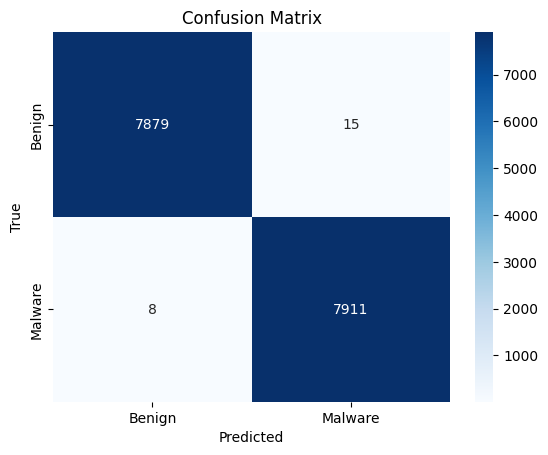

In [23]:
loss, acc , precision= model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


  1/495 ━━━━━━━━━━━━━━━━━━━━ 1:32 187ms/step - accuracy: 1.0000 - loss: 0.0016 - recall: 1.0000

160/495 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.9985 - loss: 0.0042 - recall: 0.9991  

342/495 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.9984 - loss: 0.0043 - recall: 0.9988

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.9985 - loss: 0.0041 - recall: 0.9987


Test Loss: 0.0033
Test Accuracy: 0.9988
Test precision: 0.9986
  1/495 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step

265/495 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7894
         1.0       1.00      1.00      1.00      7919

    accuracy                           1.00     15813
   macro avg       1.00      1.00      1.00     15813
weighted avg       1.00      1.00      1.00     15813



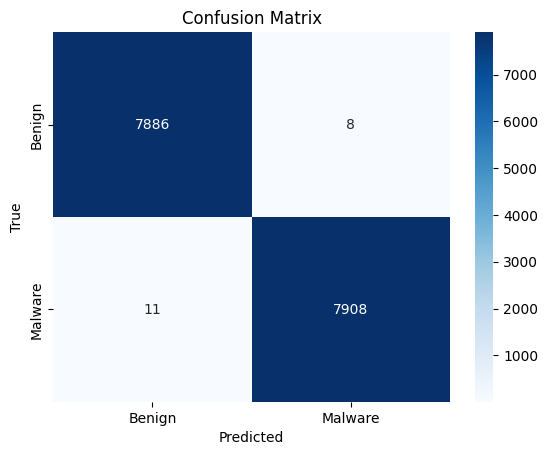

In [24]:
loss, acc , precision= lstm_bc.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (lstm_bc.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Save full model (preferred modern way)
model.save("global_FNN_model.keras")
lstm_bc.save("global_lstm_model.keras")